# Setup

In [1]:
import gc
import warnings
gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb

SEED = 2024

In [2]:
#Check GPU availability
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    DEVICE = 'cuda'
except Exception:
    DEVICE = 'cpu'

print(f'Available device: {DEVICE}')

Available device: cuda


In [3]:
DATA_DIR = '/kaggle/input/playground-series-s4e4'

train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_sub = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [4]:
%%capture
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

abalone = fetch_ucirepo(id=1) 
original = pd.concat([abalone.data.features, abalone.data.targets], axis = 1).rename({
    'Whole_weight' : 'Whole weight',
    'Shucked_weight' : 'Whole weight.1',
    'Viscera_weight' : 'Whole weight.2',
    'Shell_weight' : 'Shell weight'
}, axis = 1)

# Data overview

In [5]:
original.shape, train.shape, test.shape

((4177, 9), (90615, 10), (60411, 9))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [7]:
train.sample()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
64667,64667,I,0.32,0.24,0.085,0.1855,0.0675,0.0295,0.0355,7


In [8]:
original.sample()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
939,I,0.46,0.36,0.1,0.4635,0.2325,0.093,0.115,7


### Target distribution

In [9]:
TARGET = 'Rings'

with pd.option_context('display.precision', 3):
    display(pd.concat(
        [
            train[TARGET].describe().rename('Train'),
            original[TARGET].describe().rename('Original')
        ],
        axis=1
    ).T)

,count,mean,std,min,25%,50%,75%,max
Train,90615.0,9.697,3.176,1.0,8.0,9.0,11.0,29.0
Original,4177.0,9.934,3.224,1.0,8.0,9.0,11.0,29.0


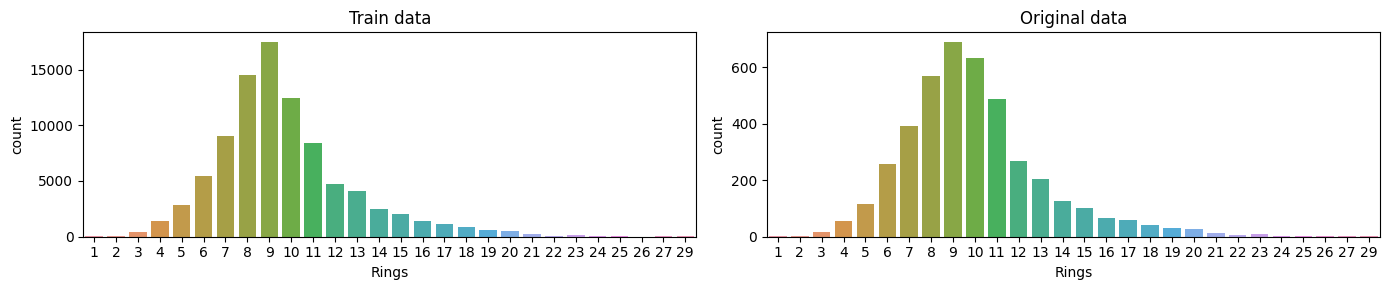

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
ax[0].set_title('Train data')
sns.countplot(x=TARGET, data=train, ax=ax[0])
ax[1].set_title('Original data')
sns.countplot(x=TARGET, data=original, ax=ax[1])
fig.tight_layout()
plt.show()

### Missing values

In [11]:
original.isna().any().sum(), train.isna().any().sum(), test.isna().any().sum()

(0, 0, 0)

### Dropping irrelevant column(s)

In [12]:
features = list(test.columns)
features.remove('id')

In [13]:
pd.concat(
    [
        train[features].nunique().rename('Train'),
        test[features].nunique().rename('Test'),
        original[features].nunique().rename('Original')
    ],
    axis=1
).T

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
Train,3,157,126,90,3175,1799,979,1129
Test,3,148,130,85,3037,1747,960,1089
Original,3,134,111,51,2429,1515,880,926


No other column needs to be dropped for now.

In [14]:
test_ids = test.pop('id')
train.drop('id', axis=1, inplace=True)

### Duplicates

Individual datasets:

In [15]:
original.drop(TARGET, axis=1).duplicated().sum(), train.drop(TARGET, axis=1).duplicated().sum(), test.duplicated().sum()

(0, 0, 0)

Train vs Test and Original vs Test:

In [16]:
pd.concat([train.drop(TARGET, axis=1), test]).duplicated().sum()

0

In [17]:
pd.concat([original.drop(TARGET, axis=1), test]).duplicated().sum()

215

We can compare predictions with original ground-truth for these 215 records.

Train vs Original:

In [18]:
pd.concat([train.drop(TARGET, axis=1), original.drop(TARGET, axis=1)]).duplicated().sum()

285

In [19]:
pd.concat([train, original]).duplicated().sum()

0

* For these 285 records, features are exactly the same but target is different.  
* Since we have a regression dataset, we should check the variation in values.  
For instance, it may be 4 vs 5 for original and train respectively.

In [20]:
merged = pd.merge(train, original, how='inner', on=features)
merged.sample(5, random_state=SEED)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings_x,Rings_y
147,F,0.580,0.45,0.145,1.1370,0.5585,0.2200,0.2900,9,8
242,I,0.275,0.22,0.080,0.1365,0.0565,0.0285,0.0420,7,6
81,F,0.665,0.54,0.195,1.7640,0.8505,0.3615,0.4700,10,11
263,F,0.605,0.47,0.165,1.1775,0.6110,0.2275,0.2920,11,9
21,M,0.710,0.56,0.175,1.7240,0.5660,0.4575,0.4625,17,13


In [21]:
# difference in target > 2
len(merged.loc[abs(merged.Rings_x - merged.Rings_y) > 2])

46

In [22]:
# difference in target > 5
len(merged.loc[abs(merged.Rings_x - merged.Rings_y) > 5])

9

* Significant difference in several cases.
* We can experiment with dropping conflicting columns during the modeling stage.

# Feature exploration

### Sex

In [23]:
with pd.option_context('display.precision', 3):
    display(pd.concat(
        [
            train.Sex.value_counts(normalize=True).rename('Train'),
            original.Sex.value_counts(normalize=True).rename('Original')
        ],
        axis=1
    ))

,Train,Original
Sex,,
I,0.365,0.321
M,0.342,0.366
F,0.292,0.313


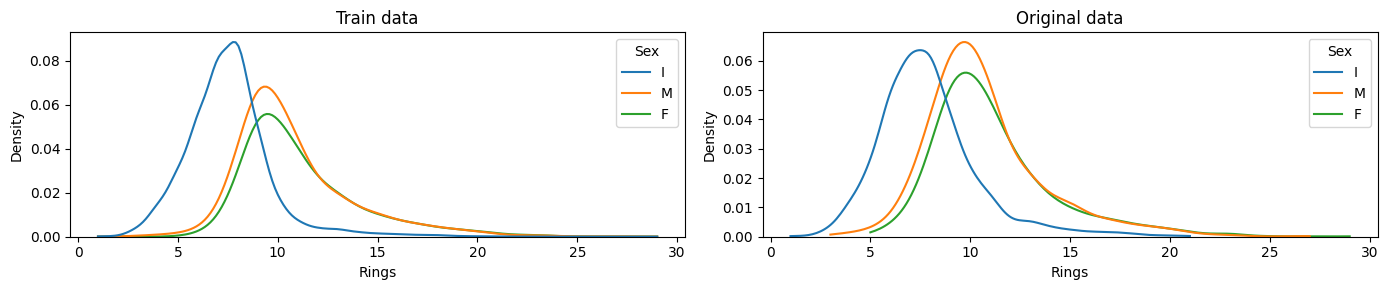

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
ax[0].set_title('Train data')
sns.kdeplot(x=TARGET, data=train, hue='Sex', hue_order=['I','M','F'], bw_adjust=2, cut=0, ax=ax[0])
ax[1].set_title('Original data')
sns.kdeplot(x=TARGET, data=original, hue='Sex', hue_order=['I','M','F'], cut=0, ax=ax[1])
fig.tight_layout()
plt.show()

In [25]:
train['is_infant'] = (train['Sex'] == 'I').astype('int')
test['is_infant'] = (test['Sex'] == 'I').astype('int')
original['is_infant'] = (original['Sex'] == 'I').astype('int')

### Length

In [26]:
def plot_cont(f):
    fig, ax = plt.subplots(nrows=3, ncols=2, height_ratios=[0.25, 0.25, 0.5], figsize=(14, 9))
    ax[0][0].set_title('Train & Test feature distribution')
    sns.kdeplot(x=f, data=train, cut=0, ax=ax[0][0], label='Train')
    sns.kdeplot(x=f, data=test, cut=0, ax=ax[0][0], label='Test')
    ax[0][0].legend(title='Dataset', fontsize=10, title_fontsize=12)
    ax[0][1].set_title('Original feature distribution')
    sns.kdeplot(x=f, data=original, cut=0, ax=ax[0][1])
    ax[1][0].set_title('Train feature vs Sex')
    sns.kdeplot(x=f, data=train, hue='Sex', hue_order=['I','M','F'], cut=0, ax=ax[1][0])
    ax[1][1].set_title('Original feature vs Sex')
    sns.kdeplot(x=f, data=original, hue='Sex', hue_order=['I','M','F'], cut=0, ax=ax[1][1])
    ax[2][0].set_title('Train feature vs target')
    sns.scatterplot(x=f, y=TARGET, data=train, hue='Sex', hue_order=['I','M','F'],ax=ax[2][0])
    ax[2][1].set_title('Original feature vs target')
    sns.scatterplot(x=f, y=TARGET, data=original, hue='Sex', hue_order=['I','M','F'],ax=ax[2][1])
    fig.tight_layout()
    plt.show()

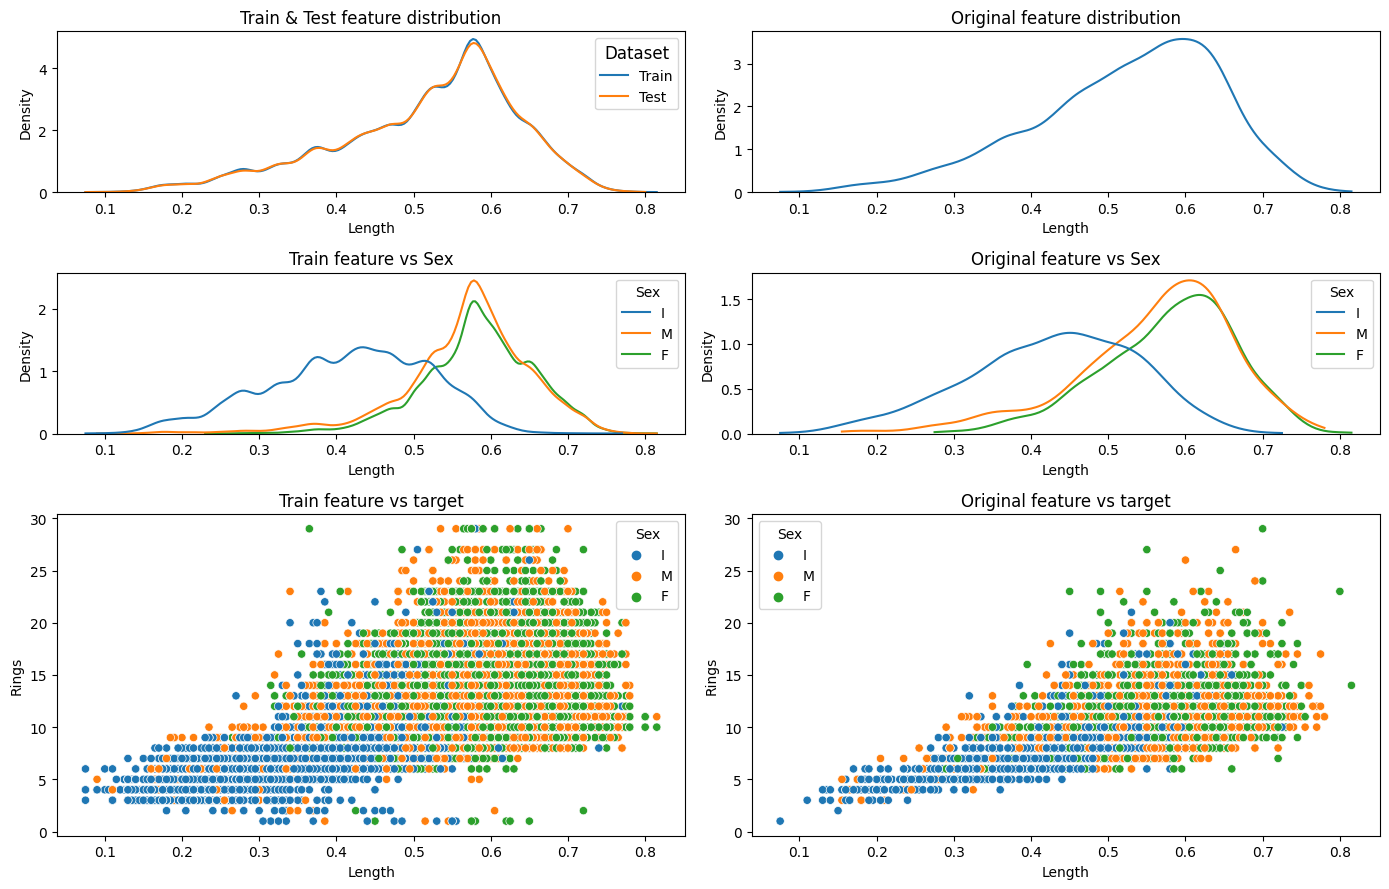

In [27]:
plot_cont('Length')

### Diameter

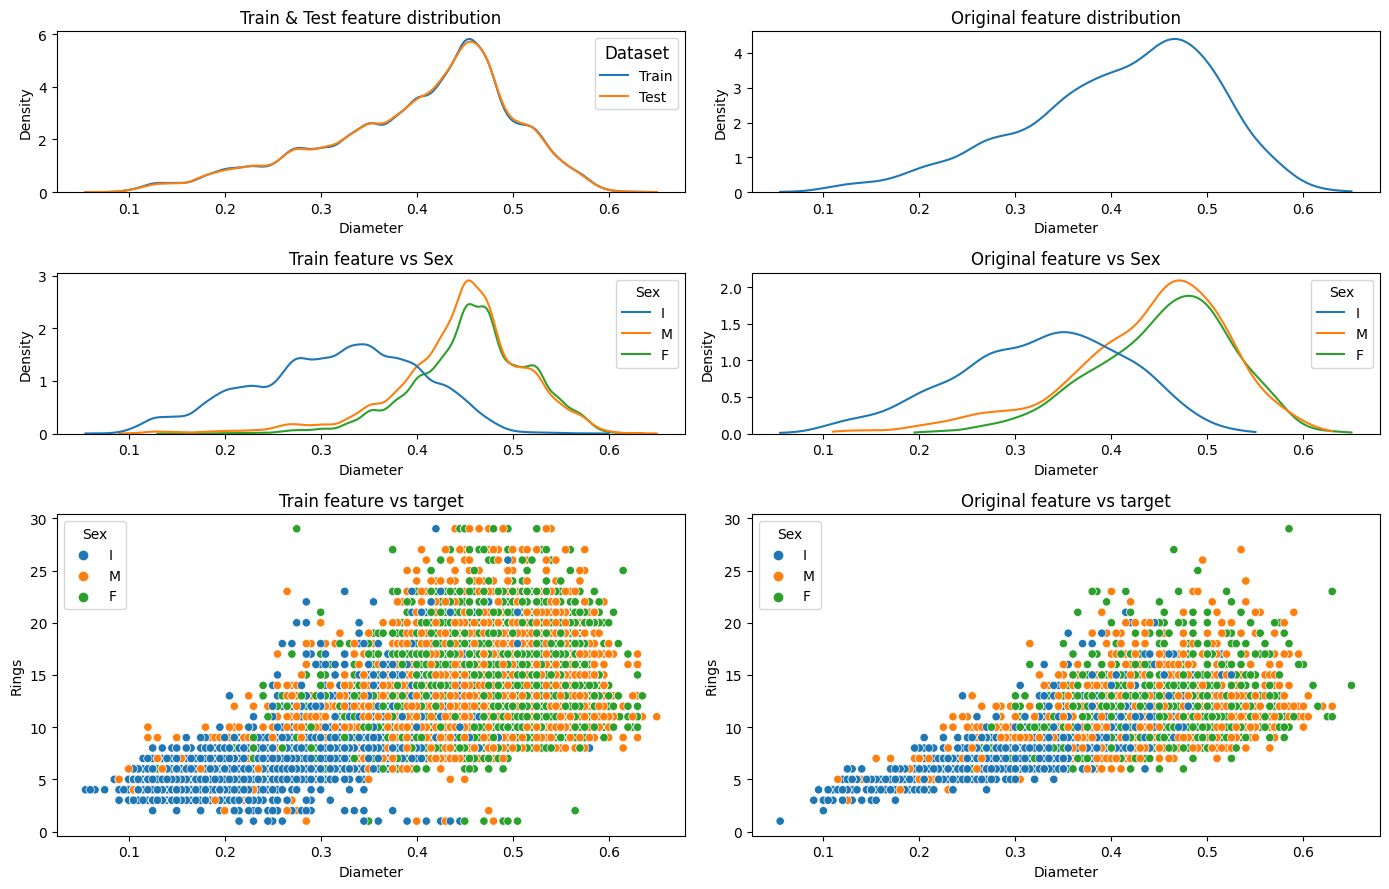

In [28]:
plot_cont('Diameter')

### Height

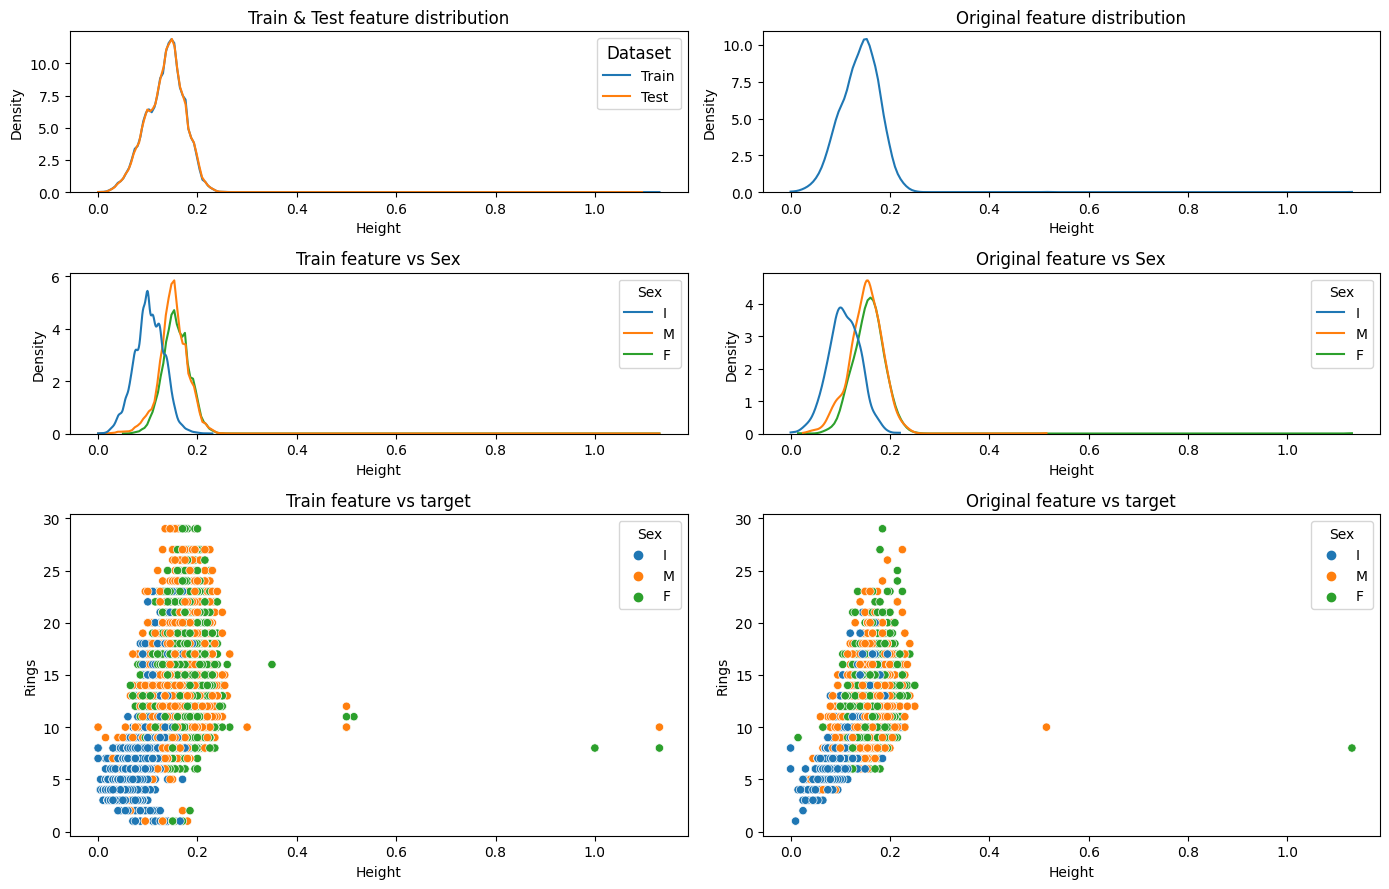

In [29]:
plot_cont('Height')

In [30]:
original.loc[original.Height > 0.4]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,is_infant
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10,0
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8,0


In [31]:
train.loc[train.Height > 0.4]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,is_infant
16384,F,0.515,0.375,1.130,0.5720,0.2370,0.1455,0.1500,8,0
28651,F,0.665,0.515,0.500,1.7825,0.5330,0.3340,0.4285,10,0
55852,M,0.745,0.545,0.500,1.7875,0.8075,0.3935,0.5650,10,0
56089,F,0.705,0.575,0.515,2.2100,1.1075,0.4865,0.5120,11,0
58048,F,0.635,0.495,0.500,1.2615,0.5385,0.3050,0.3750,11,0
63851,M,0.640,0.510,0.500,1.3715,0.5065,0.3050,0.4700,12,0
65464,M,0.585,0.450,1.130,1.1000,0.5085,0.2425,0.2800,10,0
77326,F,0.565,0.455,1.000,1.0145,0.5255,0.2440,0.2835,8,0


### Whole weight

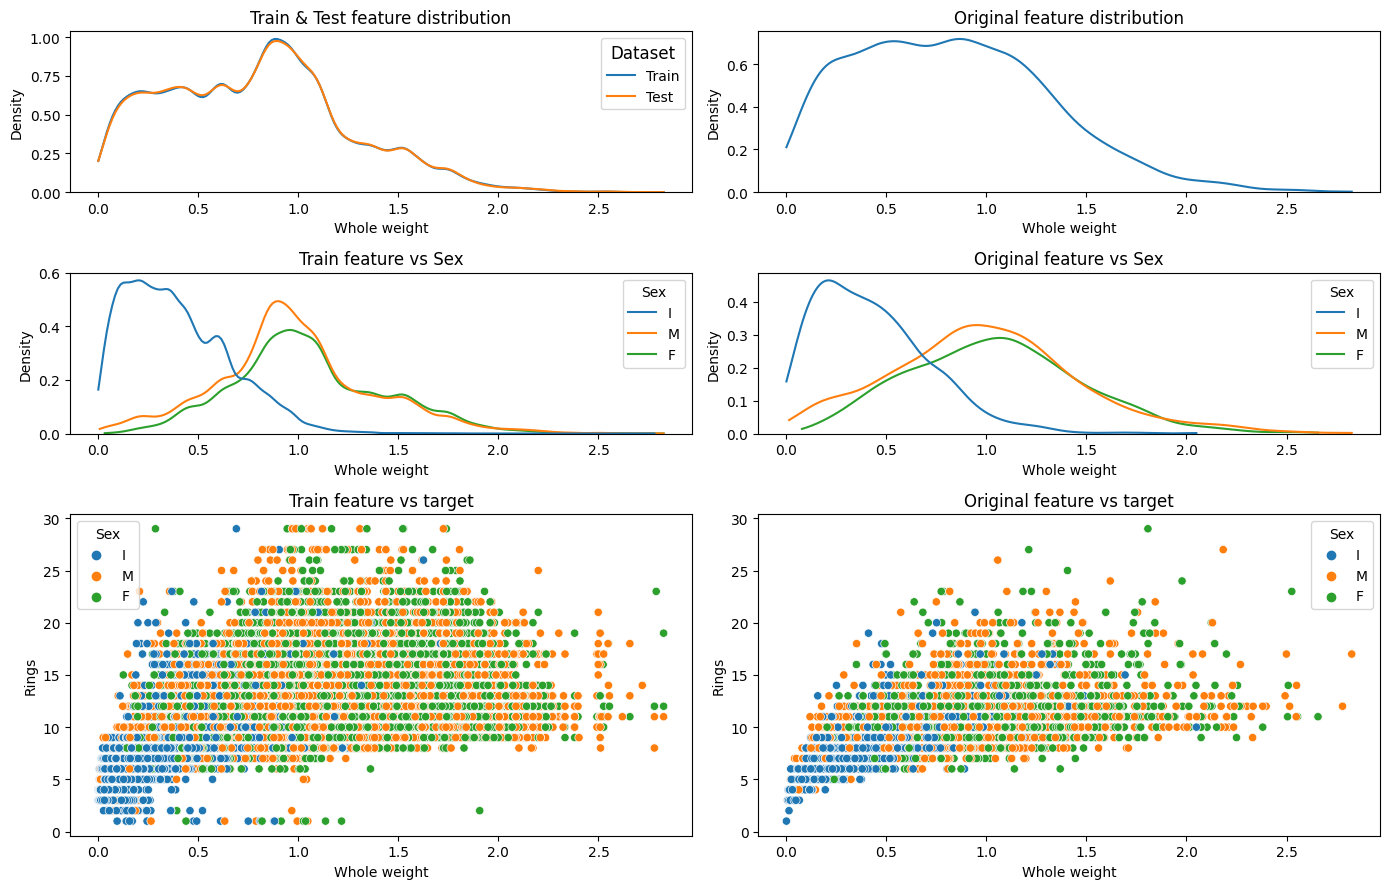

In [32]:
plot_cont('Whole weight')

### Whole weight.1

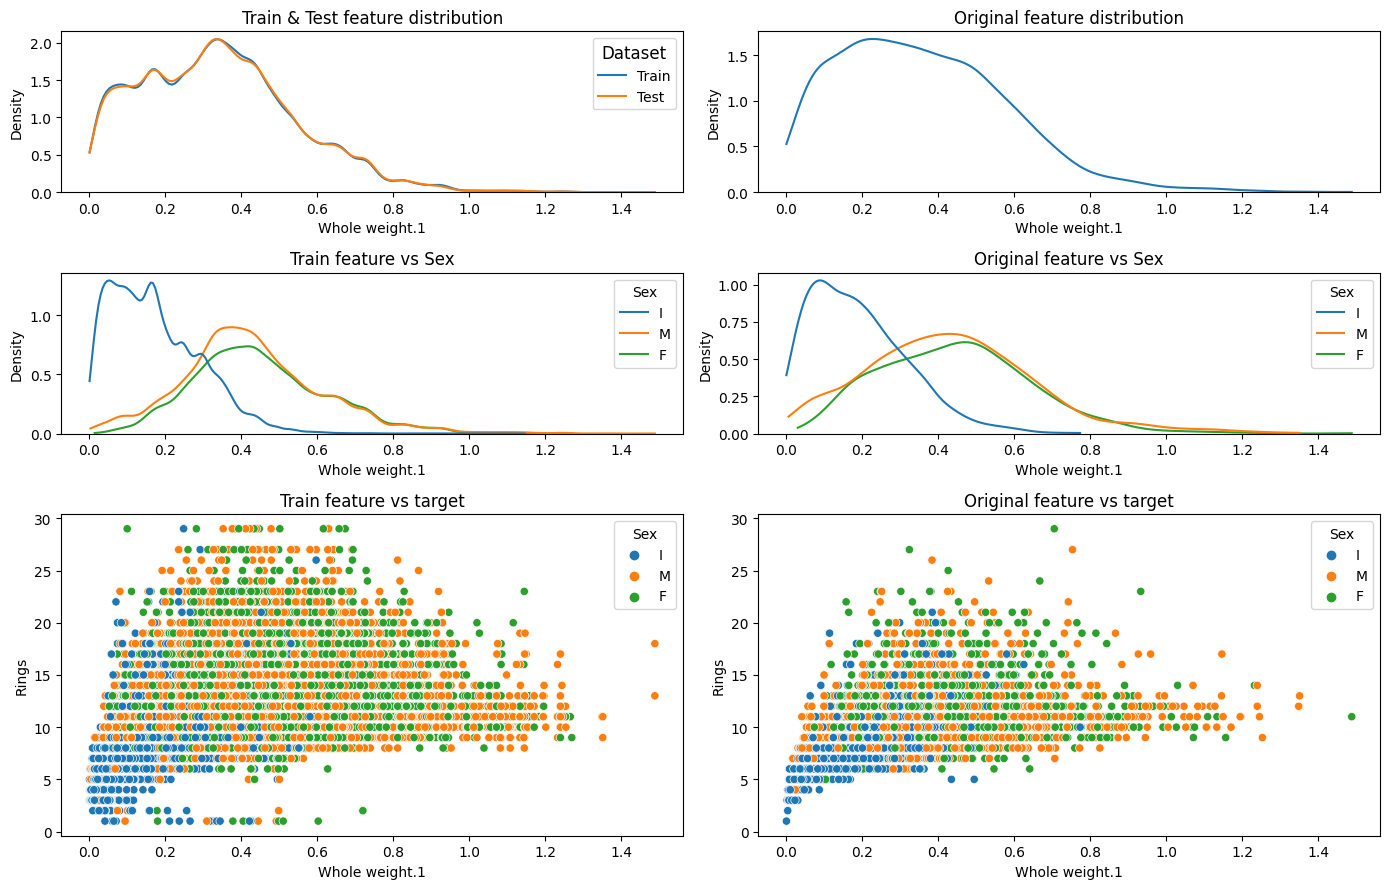

In [33]:
plot_cont('Whole weight.1')

### Whole weight.2

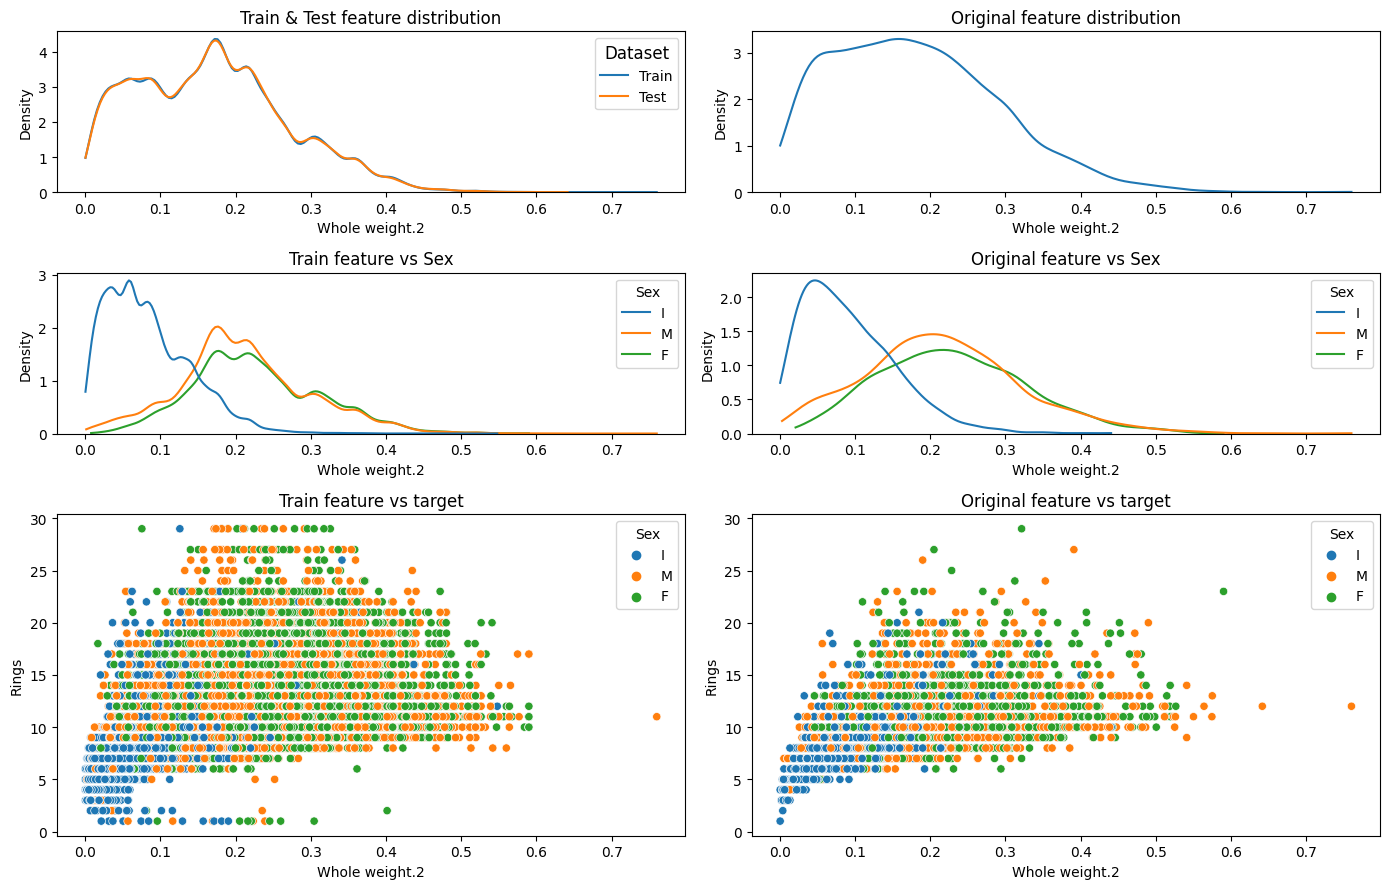

In [34]:
plot_cont('Whole weight.2')

### Shell weight

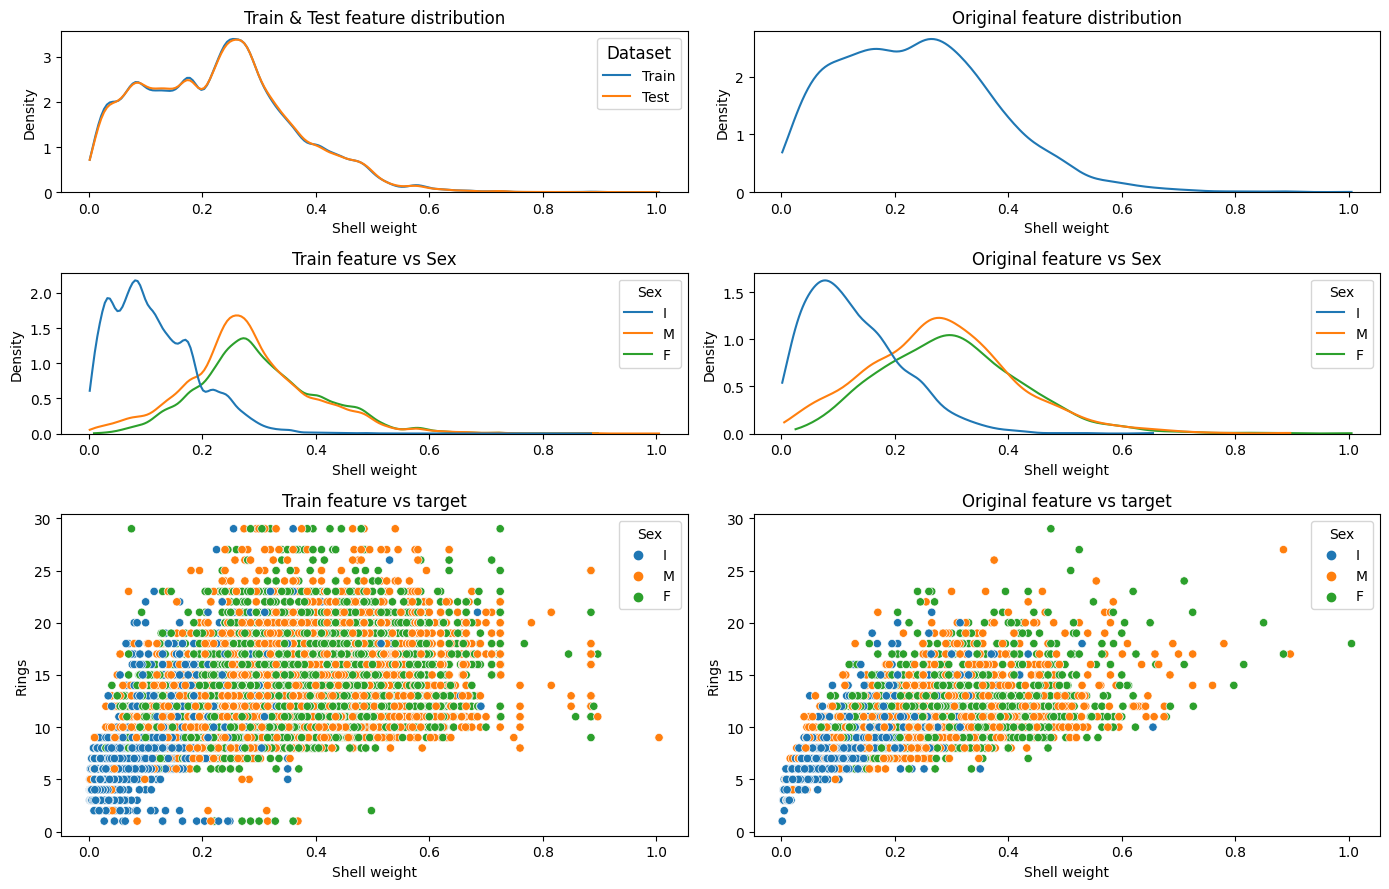

In [35]:
plot_cont('Shell weight')

# Feature selection

### Correlation

In [36]:
def plot_corr_matrix(corr_df, size=12):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        corr_df, vmin=-1, vmax=1, center=0,
        mask=np.triu(np.ones_like(corr_df)),
        annot=True, fmt='.2f', linewidths=0.1)
    plt.show()

In [37]:
num_cols = [f for f in train.columns if f not in ('Sex', 'is_infant')]

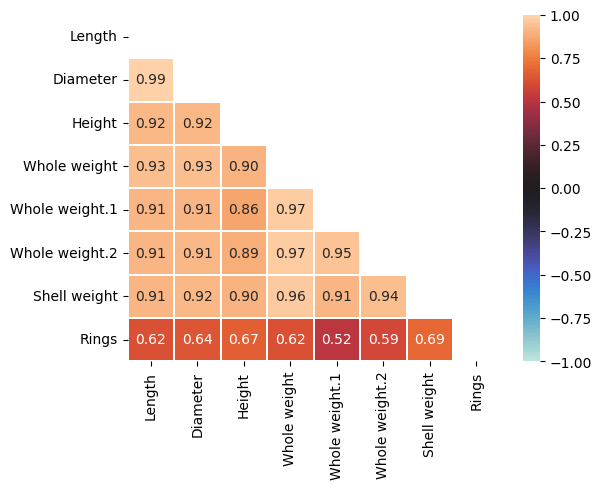

In [38]:
train_corr = train[num_cols].corr()
plot_corr_matrix(train_corr, size=6)

Very strong correlation between all features.  
Options to explore later: dropping features, PCA, compound features

### Mutual information

In [39]:
sex_mapping = {'I': 0, 'F': 1, 'M': 2}
train['Sex'] = train['Sex'].replace(sex_mapping)
test['Sex'] = test['Sex'].replace(sex_mapping)
original['Sex'] = original['Sex'].replace(sex_mapping)

In [40]:
features = list(test.columns)
cat_mask = [False] * len(features)  # boolean mask for discrete features
cat_mask[0] = True  # Sex
cat_mask[-1] = True  # is_infant

mi_scores = mutual_info_regression(train[features], train[TARGET], 
                                   discrete_features=cat_mask, 
                                   random_state=SEED)
pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,is_infant
mi_score,0.243155,0.529843,0.547147,0.55313,0.570972,0.512816,0.543561,0.677724,0.239121


# Data preparation

In [41]:
cat_features = ['Sex', 'is_infant']

train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')
original[cat_features] = original[cat_features].astype('category')

In [42]:
all_features = list(test.columns)
base_features = [f for f in all_features if f != 'is_infant']
reduced_features = ['is_infant', 'Diameter', 'Height', 'Whole weight', 'Shell weight']

# Modeling framework

In [43]:
def comp_metric(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

In [44]:
def custom_cv(features, model, extend, folds, seeds, verbose=False):
    oof_preds, test_preds = {}, {}
    scores = []
    
    X_test = test[features]
    
    for seed in seeds:
        op, tp = {}, {}
        print(f'SEED: {seed}')
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
        for fold, (train_ids, val_ids) in enumerate(cv.split(train, train[TARGET])):
            X_train = train.iloc[train_ids]
            X_val = train.iloc[val_ids]
            if extend: # concat original dataset and remove contradictory duplicates
                X_train = pd.concat([X_train, original], axis=0) \
                            .drop_duplicates(subset=features, keep='first', ignore_index=True)

            y_train, y_val = X_train.pop(TARGET), X_val.pop(TARGET)
            X_train, X_val = X_train[features], X_val[features]

            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=0)

            val_preds = model.predict(X_val)
            op.update(dict(zip(val_ids, val_preds)))
            tp[f'fold{fold}'] = model.predict(X_test)

            score = comp_metric(y_val, val_preds)
            scores.append(score)
            if verbose:
                print(f'Fold #{fold}: {score:.5f} ({model.best_iteration} rounds)')
            _ = gc.collect()

        tp = pd.DataFrame.from_dict(tp)
        tp['mean'] = tp.mean(axis=1)  # mean of fold-wise predictions

        op = pd.Series(op).sort_index()
        print(f'\tOOF: {comp_metric(train[TARGET], op):.5f}, ' \
              f'Avg: {np.mean(scores):.5f} +/- {np.std(scores):.5f}')
        oof_preds[f'{seed}'] = op
        test_preds[f'{seed}'] = tp['mean']
    
    oof_preds = pd.DataFrame.from_dict(oof_preds).mean(axis=1)
    test_preds = pd.DataFrame.from_dict(test_preds).mean(axis=1)
    print(f'\nOOF score over all seeds: {comp_metric(train[TARGET], oof_preds): .5f}\n')
    return oof_preds, test_preds

In [45]:
def create_submission_files(preds, config, notebook='00'):
    sub = pd.DataFrame({'id': test_ids, TARGET: preds})
    sub.to_csv(f'{notebook}_{config}.csv', index=False)

In [46]:
op = {}  # OOF preds
tp = {}  # Test preds

seeds = [SEED, 505, 1807, 808, 1502]

# Experiments

In [47]:
BASE_PARAMS = {
    'tree_method': 'hist',
    'eval_metric': 'rmsle',
    'n_estimators': 10000,
    'learning_rate': 0.05,
    'early_stopping_rounds': 100,
    'enable_categorical': True,
    'max_cat_to_onehot': 3,
    'device': DEVICE,
    'n_jobs': -1
}

In [48]:
%%time
feature_set = 'BASE'
dataset = 'TRN'  # train dataset only
loss = 'SQLOG'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=base_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14883, Avg: 0.14883 +/- 0.00078
SEED: 505
	OOF: 0.14883, Avg: 0.14883 +/- 0.00116
SEED: 1807
	OOF: 0.14891, Avg: 0.14885 +/- 0.00113
SEED: 808
	OOF: 0.14886, Avg: 0.14886 +/- 0.00107
SEED: 1502
	OOF: 0.14885, Avg: 0.14885 +/- 0.00106

OOF score over all seeds:  0.14849

CPU times: user 4min 45s, sys: 778 ms, total: 4min 46s
Wall time: 4min 30s


In [49]:
%%time
feature_set = 'BASE'
dataset = 'EXT'  # train + original
loss = 'SQLOG'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, loss_function='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=base_features, 
    model=model,
    extend=True,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14948, Avg: 0.14948 +/- 0.00077
SEED: 505
	OOF: 0.14954, Avg: 0.14950 +/- 0.00132
SEED: 1807
	OOF: 0.14955, Avg: 0.14952 +/- 0.00127
SEED: 808
	OOF: 0.14951, Avg: 0.14951 +/- 0.00115
SEED: 1502
	OOF: 0.14962, Avg: 0.14953 +/- 0.00110

OOF score over all seeds:  0.14900

CPU times: user 2min 32s, sys: 419 ms, total: 2min 33s
Wall time: 2min 18s


In [50]:
%%time
feature_set = 'ALL'
dataset = 'TRN'
loss = 'SQLOG'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=all_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14892, Avg: 0.14892 +/- 0.00072
SEED: 505
	OOF: 0.14882, Avg: 0.14887 +/- 0.00111
SEED: 1807
	OOF: 0.14892, Avg: 0.14888 +/- 0.00110
SEED: 808
	OOF: 0.14884, Avg: 0.14887 +/- 0.00105
SEED: 1502
	OOF: 0.14883, Avg: 0.14886 +/- 0.00105

OOF score over all seeds:  0.14851

CPU times: user 4min 42s, sys: 671 ms, total: 4min 42s
Wall time: 4min 26s


In [51]:
%%time
feature_set = 'RED'
dataset = 'TRN'
loss = 'SQLOG'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=reduced_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.15971, Avg: 0.15971 +/- 0.00099
SEED: 505
	OOF: 0.15970, Avg: 0.15970 +/- 0.00105
SEED: 1807
	OOF: 0.15979, Avg: 0.15973 +/- 0.00108
SEED: 808
	OOF: 0.15975, Avg: 0.15973 +/- 0.00120
SEED: 1502
	OOF: 0.15964, Avg: 0.15971 +/- 0.00119

OOF score over all seeds:  0.15941

CPU times: user 2min 20s, sys: 532 ms, total: 2min 21s
Wall time: 2min 8s


In [52]:
%%time
feature_set = 'ALL'
dataset = 'TRN'
loss = 'SQR'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squarederror')
op[config], tp[config] = custom_cv(
    features=all_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14966, Avg: 0.14966 +/- 0.00073
SEED: 505
	OOF: 0.14973, Avg: 0.14969 +/- 0.00123
SEED: 1807
	OOF: 0.14976, Avg: 0.14971 +/- 0.00125
SEED: 808
	OOF: 0.14964, Avg: 0.14970 +/- 0.00115
SEED: 1502
	OOF: 0.14965, Avg: 0.14969 +/- 0.00108

OOF score over all seeds:  0.14914

CPU times: user 2min 30s, sys: 390 ms, total: 2min 30s
Wall time: 2min 16s


In [53]:
%%time
feature_set = 'ALL'
dataset = 'TRN'
loss = 'SQABS'
folds = 7
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:absoluteerror')
op[config], tp[config] = custom_cv(
    features=all_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.15283, Avg: 0.15283 +/- 0.00107
SEED: 505
	OOF: 0.15292, Avg: 0.15287 +/- 0.00133
SEED: 1807
	OOF: 0.15286, Avg: 0.15287 +/- 0.00124
SEED: 808
	OOF: 0.15308, Avg: 0.15292 +/- 0.00117
SEED: 1502
	OOF: 0.15277, Avg: 0.15289 +/- 0.00114

OOF score over all seeds:  0.15231

CPU times: user 2min 35s, sys: 8.27 s, total: 2min 43s
Wall time: 2min 27s


In [54]:
%%time
feature_set = 'ALL'
dataset = 'TRN'
loss = 'SQLOG'
folds = 10
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=all_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14887, Avg: 0.14886 +/- 0.00087
SEED: 505
	OOF: 0.14877, Avg: 0.14881 +/- 0.00169
SEED: 1807
	OOF: 0.14887, Avg: 0.14883 +/- 0.00153
SEED: 808
	OOF: 0.14874, Avg: 0.14881 +/- 0.00144
SEED: 1502
	OOF: 0.14882, Avg: 0.14881 +/- 0.00141

OOF score over all seeds:  0.14851

CPU times: user 6min 31s, sys: 3.53 s, total: 6min 34s
Wall time: 6min 11s


In [55]:
%%time
feature_set = 'ALL'
dataset = 'TRN'
loss = 'SQLOG'
folds = 15
config = f'feat{feature_set}_data{dataset}_loss{loss}_fold{folds}'

model = xgb.XGBRegressor(**BASE_PARAMS, objective='reg:squaredlogerror')
op[config], tp[config] = custom_cv(
    features=all_features, 
    model=model,
    extend=False,
    folds=folds,
    seeds=seeds)

create_submission_files(tp[config], config)

SEED: 2024
	OOF: 0.14876, Avg: 0.14876 +/- 0.00121
SEED: 505
	OOF: 0.14876, Avg: 0.14875 +/- 0.00187
SEED: 1807
	OOF: 0.14882, Avg: 0.14877 +/- 0.00179
SEED: 808
	OOF: 0.14877, Avg: 0.14876 +/- 0.00185
SEED: 1502
	OOF: 0.14877, Avg: 0.14876 +/- 0.00189

OOF score over all seeds:  0.14853

CPU times: user 9min 40s, sys: 4.14 s, total: 9min 44s
Wall time: 9min 9s


**Time to submit!**